In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from pandas.plotting import table
import scienceplots

In [2]:
# Load data
df_auto = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_single = pd.read_csv('./project_pipeline/data/single_domain_pae.tsv', sep='\t').astype('object')
df_multi = pd.read_csv('./project_pipeline/data/multi_domain_pae.tsv', sep='\t').astype('object')
cl = pd.read_csv('./project_pipeline/data/classified_files.tsv', sep='\t').astype('object')

df_auto = df_auto.drop_duplicates(subset=['uniprot']).reset_index(drop=True)

In [3]:
plt.style.use('science')

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Paired')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
colors = {'Single Domain': pal[0], 'Two-Domain': pal[1], 'Autoinhibitory': pal[3], 'Autoinhibitory (Active)': pal[2], 'Autoinhibitory (Autoinhibited)': pal[3], 
          'Full': pal[3], 'Clusters': pal[7], 'Two-State AI': pal[7], 'Autoinhibitory (Closed)': pal[5], 'Autoinhibitory (Open)': pal[4]}
pal.as_hex()

['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']


['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

Reformat the dataframes

In [4]:
df_pae = df_auto[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']]

# Remove all rows with multiple regions. Comment this out if you want to see the difference.
for i in range(len(df_single)):
    region = df_single.loc[i, 'region']
    count = region.count('-')
    if count > 1:
        df_single = df_single.drop(i)


# Reformat the singles dataframe
df_single = df_single[['uniprot', 'mean_pae']].dropna()
df_single = df_single.astype({'mean_pae': 'float'})
df_single = df_single.rename(columns={'mean_pae': 'Single Domain'})
df_single_melt = df_single.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

# Reformat all pae dataframe
df_pae = df_pae.rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM on FD', 'mean_pae_2_2': 'FD'})
df_pae_melt = df_pae.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Reformat the multi dataframe
df_multi = df_multi[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_multi = df_multi.rename(columns={'mean_pae_1_1': 'D1', 'mean_pae_1_2': 'D1 on D2', 'mean_pae_2_2': 'D2'})
df_multi_melt = df_multi.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Add type column
df_pae_melt['type'] = 'Autoinhibitory'
df_single_melt['type'] = 'Single Domain'
df_multi_melt['type'] = 'Two-Domain'

# Merge all dataframes
df_all = pd.concat([df_single_melt, df_pae_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_all['mean_pae'] = df_all['mean_pae'].astype('float')

/tmp/ipykernel_1393560/3028781824.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D2_Two-Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.046e-13 U_stat=9.080e+02
D1_Two-Domain vs. IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:7.503e-04 U_stat=2.070e+03
D1 on D2_Two-Domain vs. IM on FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.781e-03 U_stat=2.219e+03
Single Domain_Single Domain vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.522e-05 U_stat=9.643e+03
Single Domain_Single Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.941e-05 U_stat=1.119e+04
Single Domain_Single Domain vs. D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferro

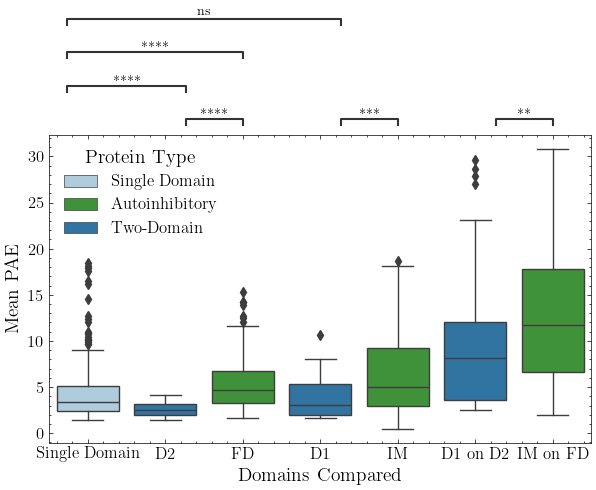

In [5]:
region_order = ['Single Domain', 'D2', 'FD', 'D1', 'IM', 'D1 on D2', 'IM on FD']

f, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=df_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Mean PAE', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12') 

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD', 'Autoinhibitory')],
         [('Single Domain', 'Single Domain'), ('D2', 'Two-Domain')],
         [('Single Domain', 'Single Domain'), ('D1', 'Two-Domain')],
         [('FD', 'Autoinhibitory'), ('D2', 'Two-Domain')],
         [('IM', 'Autoinhibitory'), ('D1', 'Two-Domain')],
         [('IM on FD', 'Autoinhibitory'), ('D1 on D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/auto_sd_md_proteins_pae_annotated.png')

We'll make a table for all the types of our proteins

Single Domain     258
Autoinhibitory    123
Two-Domain         53
Name: type, dtype: int64


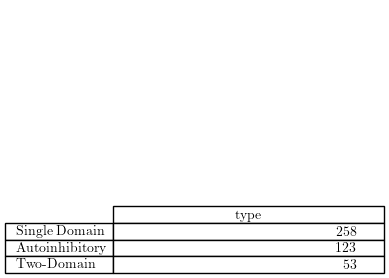

In [6]:
subAll = df_all[['uniprot', 'type']]
subAll = subAll.drop_duplicates()

# Get the number of proteins in each category
counts = subAll['type'].value_counts()
print(counts)

ax = plt.subplot(111, frame_on=False)
table(ax, counts)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.savefig('./project_pipeline/data/figures/auto_sd_md_proteins_pae_table.png')

# Plot for PAE of 2-State Autoinhibitory Proteins Compared to Single Domain and Two-Domain Proteins

Now we're going to look at 2-state autoinhibitory proteins

In [7]:
# Determine which proteins from cl have both active and autoinhibited structures
both = cl.groupby('uniprot').filter(lambda x: x['state'].nunique() > 1)

# Get the list of uniprots
uniprots = both['uniprot'].unique()

# Filter for these proteins in the pae dataframe
df_both_melt = df_pae_melt[df_pae_melt['uniprot'].isin(uniprots)].reset_index(drop=True)
df_both_melt['type'] = 'Two-State AI'


# Merge the dataframes
df_all2 = pd.concat([df_single_melt, df_both_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_all2['mean_pae'] = df_all2['mean_pae'].astype('float')

/tmp/ipykernel_1393560/3444118814.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D2_Two-Domain vs. FD_Two-State AI: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.099e-05 U_stat=1.610e+02
D1_Two-Domain vs. IM_Two-State AI: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.149e-02 U_stat=2.940e+02
D1 on D2_Two-Domain vs. IM on FD_Two-State AI: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:8.744e-02 U_stat=3.320e+02
Single Domain_Single Domain vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.522e-05 U_stat=9.643e+03
Single Domain_Single Domain vs. FD_Two-State AI: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:7.367e-01 U_stat=2.045e+03
Single Domain_Single Domain vs. D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni corre

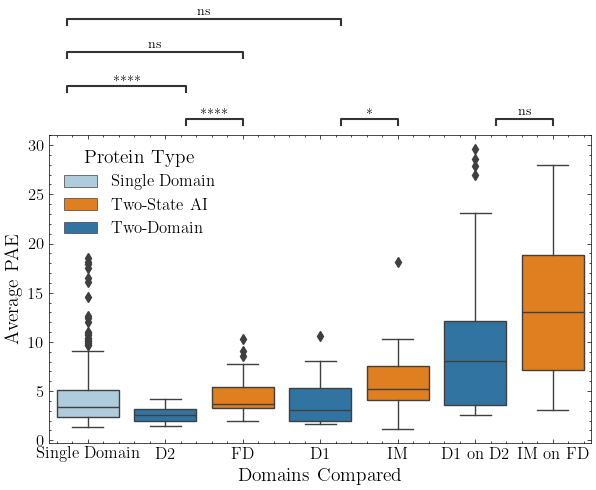

In [8]:
region_order = ['Single Domain', 'D2', 'FD', 'D1', 'IM', 'D1 on D2', 'IM on FD']

f, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=df_all2, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
ax.set_xlabel('Domains Compared', fontsize=14)
ax.set_ylabel('Average PAE', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Protein Type', title_fontsize='14', fontsize='12')

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD', 'Two-State AI')],
         [('Single Domain', 'Single Domain'), ('D2', 'Two-Domain')],
         [('Single Domain', 'Single Domain'), ('D1', 'Two-Domain')],
         [('FD', 'Two-State AI'), ('D2', 'Two-Domain')],
         [('IM', 'Two-State AI'), ('D1', 'Two-Domain')],
         [('IM on FD', 'Two-State AI'), ('D1 on D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all2, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/auto2state_sd_md_proteins_pae_annotated.png')

    uniprot          type
258  O00571  Two-State AI
259  O08967  Two-State AI
260  O60741  Two-State AI
261  P07038  Two-State AI
262  P12931  Two-State AI
263  P21333  Two-State AI
264  P22681  Two-State AI
265  P26358  Two-State AI
266  P27577  Two-State AI
267  P28482  Two-State AI
268  P29350  Two-State AI
269  P35520  Two-State AI
270  P53042  Two-State AI
271  P60240  Two-State AI
272  P62826  Two-State AI
273  Q00944  Two-State AI
274  Q6GQQ9  Two-State AI
275  Q8NQJ3  Two-State AI
276  Q96BN8  Two-State AI
277  Q9Y6K1  Two-State AI
Single Domain    258
Two-Domain        53
Two-State AI      20
Name: type, dtype: int64


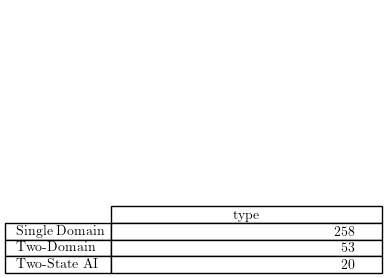

In [9]:
# And a table for these too
subAll = df_all2[['uniprot', 'type']]
subAll = subAll.drop_duplicates()

twotypes = subAll[subAll['type'] == 'Two-State AI']
print(twotypes)

# Get the number of proteins in each category
counts = subAll['type'].value_counts()
print(counts)

ax = plt.subplot(111, frame_on=False)
table(ax, counts)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.savefig('./project_pipeline/data/figures/auto2state_sd_md_proteins_pae_table.png')

I would like to make my own visualization of the PAE matrix, so this is what this section is for.

In [10]:
sns.set_theme(font_scale=1.2)

# Read in the desired JSON matrix and format it to a dataframe
file = './project_pipeline/data/input/Alphafold_cif/F-O43739-F1-predicted_aligned_error_v3.json'
scores = json.loads(open(file).read())
pae = scores[0]['predicted_aligned_error']

df = pd.DataFrame(pae)
df.loc[max(df.index) + 1, :] = None
df.loc[:, max(df.columns) + 1] = None
df = df.shift(periods=1, axis=1)
df = df.shift(periods=1, axis=0)
df = df.drop(columns=0, index=0)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
1,0.0,1.0,3.0,4.0,5.0,7.0,9.0,11.0,14.0,16.0,...,30.0,31.0,30.0,31.0,31.0,31.0,31.0,30.0,30.0,29.0
2,2.0,0.0,1.0,3.0,5.0,5.0,7.0,8.0,11.0,14.0,...,30.0,30.0,31.0,30.0,31.0,30.0,30.0,30.0,30.0,29.0
3,3.0,2.0,0.0,1.0,3.0,4.0,6.0,7.0,9.0,12.0,...,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,30.0
4,4.0,3.0,2.0,0.0,1.0,2.0,4.0,6.0,7.0,9.0,...,30.0,30.0,31.0,30.0,31.0,30.0,30.0,30.0,30.0,30.0
5,4.0,5.0,4.0,2.0,0.0,1.0,3.0,4.0,6.0,8.0,...,31.0,31.0,31.0,30.0,31.0,31.0,31.0,30.0,31.0,30.0


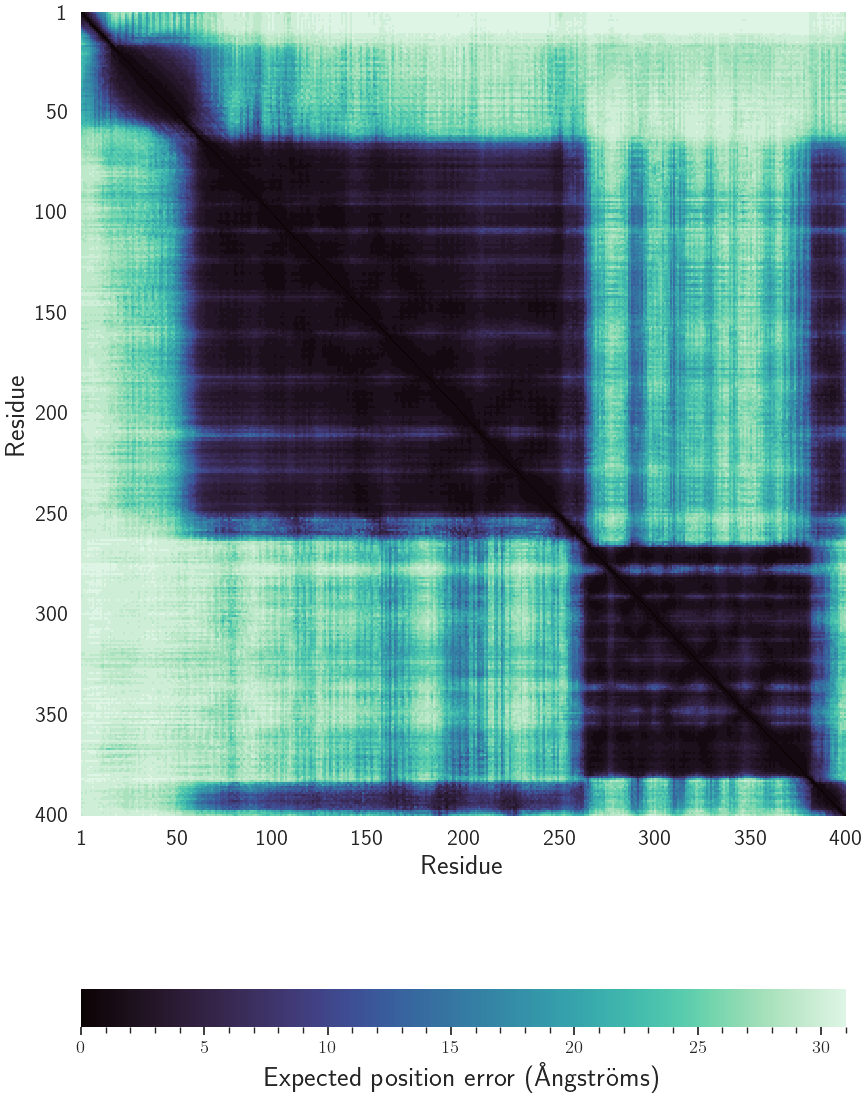

In [11]:

ticklabels = [1, 50, 100, 150, 200, 250, 300, 350, 400]

fig, ax = plt.subplots(figsize=(9, 12))
sns.heatmap(df, cmap='mako', ax=ax, cbar_kws={'label': 'Expected position error (Ångströms)', 'location': 'bottom'})
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    top=False,
    right=False
)
ax.set_ylabel('Residue', fontsize=20)
ax.set_xlabel('Residue', fontsize=20)
ax.set_yticks(ticklabels)
ax.set_xticks(ticklabels)
ax.set_xticklabels((f'{x}' for x in ticklabels), rotation=0, fontsize=16)
ax.set_yticklabels((f'{x}' for x in ticklabels), fontsize=16)
ax.figure.axes[-1].set_xlabel('Expected position error (Ångströms)', size=20)

plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/pae_heatmap.png')